In [1]:
## A Notebook to make plots from basin and catchment stats

In [2]:
from dask.distributed import Client
from dask.diagnostics import ProgressBar
import dask
import dask.delayed
import numpy as np
import xarray as xr
import geopandas as gpd

import hvplot.xarray
from matplotlib import pyplot as plt
from rasterio import RasterioIOError
from tqdm.autonotebook import tqdm
%matplotlib inline

import sklearn.linear_model
import skimage.morphology
import skimage.segmentation
import skimage.future
#import richdem as rd
import scipy.ndimage
import dask
import math
import scipy.sparse
import shapefile
import shapely
import rioxarray
from shapely.geometry import mapping
import networkx as nx
import matplotlib
import pandas as pd

#import cv2
import gcsfs
import json
import dask.dataframe
import matplotlib as mpl

<ipython-input-2-4e545aef8ae1>:12: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [3]:
import os
import dask
from dask_gateway import Gateway
from dask.distributed import Client
import dask_gateway
import dask.array as da

## Open Cluster

In [4]:
# get the dask-gateway version
dask_gateway.__version__

# show the default dask-gateway settings
dask.config.config['gateway']

# show the current default image to be started on workers
os.environ['JUPYTER_IMAGE_SPEC']

# use the same GDAL environment settings as we did for the single COG case
env = dict(GDAL_DISABLE_READDIR_ON_OPEN='EMPTY_DIR', 
           AWS_NO_SIGN_REQUEST='YES',
           GDAL_MAX_RAW_BLOCK_CACHE_SIZE='200000000',
           GDAL_SWATH_SIZE='200000000',
           VSI_CURL_CACHE_SIZE='200000000')
os.environ.update(env)

gateway = Gateway()
#options = gateway.cluster_options()
#options.environment = env 
#cluster = gateway.new_cluster(options)
#cluster.scale(4) # let's get the same number of "workers" as our previous LocalCluster examples
cluster = gateway.new_cluster()

gateway.list_clusters()

[ClusterReport<name=prod.2422e6664c5c482d89ac0377b44232dd, status=RUNNING>,
 ClusterReport<name=prod.0f2b3a9bc3834accba6f73c9282910d3, status=RUNNING>]

In [6]:
gateway.stop_cluster(gateway.list_clusters()[0].name)
gateway.list_clusters()

[ClusterReport<name=prod.885958c28c4340d08056a685de821c27, status=RUNNING>]

In [4]:
ice_shelves = ['Amery', 'Baudouin', 'Nivl']

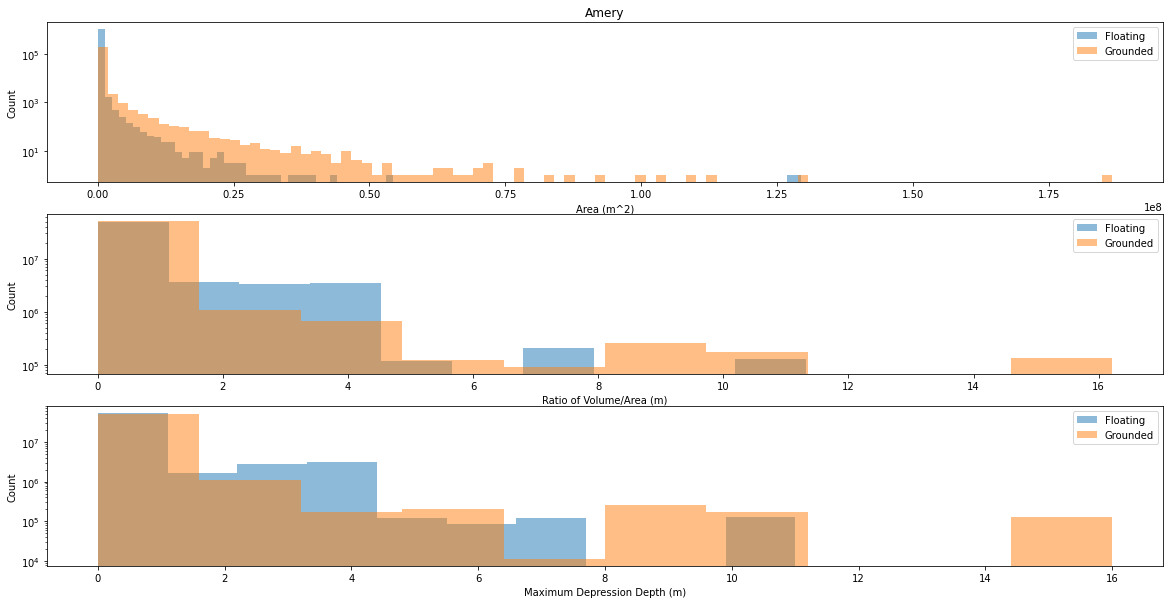

In [137]:
ice_shelf = 'Amery'

# Comparison of Area, V/A Ratio, and Max Depth of Grounded vs Floating Catchments

DB_merged_prop = pd.read_csv(str(ice_shelf+'_DB_merged_prop.csv'))

DB_merged_prop = DB_merged_prop.drop(columns='Unnamed: 0')

DB_merged_prop = dask.dataframe.from_pandas(DB_merged_prop,npartitions=10)

DB_ice_shelf_vulnerability = pd.read_csv(ice_shelf+'_ice_shelf_vulnerability.csv')
DB_merged_prop = DB_merged_prop.assign(is_floating = np.greater_equal(DB_ice_shelf_vulnerability.vulnerability,0))
del DB_ice_shelf_vulnerability

Floating = DB_merged_prop[DB_merged_prop.is_floating==True]
Grounded = DB_merged_prop[DB_merged_prop.is_floating==False]

fig, ax = plt.subplots(nrows=3, ncols=1, figsize= (20,10))

ax[0].set_title(ice_shelf)

max_area = Floating.Area_in_m.max().compute()
ax[0].hist(Floating.Area_in_m, 100,[0,max_area], alpha=0.5, label='Floating')
max_area = Grounded.Area_in_m.max().compute()
ax[0].hist(Grounded.Area_in_m, 100,[0,max_area], alpha=0.5, label='Grounded')
ax[0].set_yscale('log')
ax[0].set_ylabel('Count')
ax[0].set_xlabel('Area (m^2)')
ax[0].legend(loc='upper right')

max_ratio = Floating.volume_to_area_ratio.max().compute()
ax[1].hist(Floating.volume_to_area_ratio, 10,[0,max_ratio], weights=Floating.area,  alpha=0.5, label='Floating')
max_ratio = Grounded.volume_to_area_ratio.max().compute()
ax[1].hist(Grounded.volume_to_area_ratio, 10,[0,max_ratio],weights=Grounded.area, alpha=0.5, label='Grounded')
ax[1].set_yscale('log')
ax[1].set_ylabel('Count')
ax[1].set_xlabel('Ratio of Volume/Area (m)')
ax[1].legend(loc='upper right')

max_depth =  Floating.max_depth.max().compute()
ax[2].hist(Floating.max_depth, 10,[0,max_depth],weights=Floating.area, alpha=0.5, label='Floating')
max_depth =  Grounded.max_depth.max().compute()
ax[2].hist(Grounded.max_depth, 10,[0,max_depth],weights=Grounded.area, alpha=0.5, label='Grounded')
ax[2].set_yscale('log')
ax[2].set_ylabel('Count')
ax[2].set_xlabel('Maximum Depression Depth (m)')
ax[2].legend(loc='upper right')

## Compare segmentation based on volume/area to segmentation based on MEASUReS velocity

In [5]:
ice_shelf = 'Amery'
area_to_volume_map = xr.open_dataarray(ice_shelf+'_large_lake_drainage_area_to_volume.nc')

In [6]:
cd REMAWaterRouting/

/home/jovyan/REMAWaterRouting


In [7]:
IS = gpd.read_file('Functions/IceShelf_Antarctica_v02/IceShelf_Antarctica_v02.shp') 
ice_shelf_shape = IS[IS.NAME==ice_shelf]
[minx,miny,maxx,maxy]= ice_shelf_shape.bounds.values.tolist()[0]
bbox = shapely.geometry.asPolygon([[minx,miny],[maxx,miny],[maxx,maxy],[minx,maxy],[minx,miny]])


<AxesSubplot:>

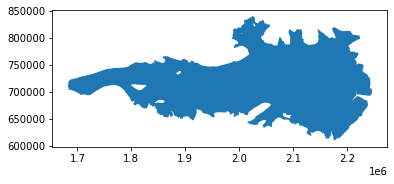

In [8]:
cd

/home/jovyan


In [9]:
cd REMAWaterRouting/

/home/jovyan/REMAWaterRouting


In [10]:
#read in the REMA tile index
REMA_index = gpd.read_file('Functions/REMA_Tile_Index/REMA_Tile_Index_Rel1_1.shp')


#bounding box of ice shelf
[minx,miny,maxx,maxy]= ice_shelf_shape.bounds.values.tolist()[0]

bbox = shapely.geometry.asPolygon([[minx,miny],[maxx,miny],[maxx,maxy],[minx,maxy],[minx,miny]])

IS_intersection = np.argwhere(REMA_index.overlaps(bbox).tolist())

IS_tiles = REMA_index.tile[IS_intersection.flatten()]

row=np.zeros((len(IS_tiles),1))
col=np.zeros((len(IS_tiles),1))
for i in np.arange(0,len(IS_tiles)):
    [row[i],col[i]] = str.split(IS_tiles.to_list()[i],sep='_')


row = np.int_(row)
col = np.int_(col)

#Load the REMA tiles lazily
uri_fmt = 'https://storage.googleapis.com/pangeo-pgc/8m/{i_idx:02d}_{j_idx:02d}/{i_idx:02d}_{j_idx:02d}_8m_dem_COG_LZW.tif'

chunksize = 8 * 512
rows = []
for i in tqdm(np.arange(row.max(), row.min()-1, -1)): #this tile range is Amery Ice Shelf
    cols = []
    for j in np.arange(col.min(),col.max()+1):
        uri = uri_fmt.format(i_idx=i, j_idx=j)
        try:
            dset = xr.open_rasterio(uri, chunks=chunksize)
            dset_masked = dset.where(dset > 0.0)
            cols.append(dset_masked)
            #print(uri)
        except RasterioIOError:
            pass
    rows.append(cols)

dsets_rows = [xr.concat(row, 'x') for row in rows]
ds = xr.concat(dsets_rows, 'y', )
ds.data

ds_array = ds.squeeze()
ds_array.data
ds_clipped = ds_array.rio.clip_box(minx,miny,maxx,maxy)
n=4

filled=True
rem_x = np.remainder(ds_clipped.shape[0],n)
rem_y = np.remainder(ds_clipped.shape[1],n)
ds_clipped.data[ds_clipped.data<0]=np.nan
coarsed_masked_array = ds_clipped[rem_x:,rem_y:].coarsen(x=n,y=n).mean()

coarsed_masked_array.shape
coarsed_masked_array = coarsed_masked_array.chunk((3000,3000))
sample = coarsed_masked_array
sample

  0%|          | 0/3 [00:00<?, ?it/s]

/srv/conda/envs/notebook/lib/python3.8/site-packages/pyproj/crs/crs.py:280: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  projstring = _prepare_from_string(projparams)


<xarray.DataArray (y: 7210, x: 17652)>
dask.array<rechunk-merge, shape=(7210, 17652), dtype=float32, chunksize=(3000, 3000), chunktype=numpy.ndarray>
Coordinates:
    band         int64 1
  * y            (y) float64 8.401e+05 8.401e+05 8.4e+05 ... 6.094e+05 6.094e+05
  * x            (x) float64 1.682e+06 1.682e+06 ... 2.247e+06 2.247e+06
    spatial_ref  int64 0

In [35]:
xr.open_dataarray('Amery_32m_filtered.nc')

<xarray.DataArray 'filtered' (y: 6250, x: 18750)>
[117187500 values with dtype=float64]
Coordinates:
    band     int64 ...
  * y        (y) float64 8e+05 8e+05 7.999e+05 ... 6.001e+05 6e+05 6e+05
  * x        (x) float64 1.6e+06 1.6e+06 1.6e+06 ... 2.2e+06 2.2e+06 2.2e+06

In [11]:
cd

/home/jovyan


In [12]:
with open('ldeo-glaciology-bc97b12df06b.json') as token_file:
    token = json.load(token_file)
gcs = gcsfs.GCSFileSystem(token=token)
mapper = gcs.get_mapper(np.str('gs://ldeo-glaciology/REMA/processed/'+ice_shelf))


processed = xr.open_zarr(mapper)  


processed.attrs.update({'crs':'+init=epsg:3031'})
processed.rio.set_crs('+init=epsg:3031')
processed.attrs.update({'transform': (32.0, 0.0, 1600000.0, 0.0, -32.0, 800000.0)})
processed.attrs.update({'res': (32.0, 32.0)})
processed.attrs.update({'is_tiled': 1})
processed.attrs.update({'nodatavals': (-9999.0,)})
processed.attrs.update({'scales': (1.0,)})
processed.attrs.update({'offsets': (0.0,)})

DB_label = processed.DB_unfilled.astype(int)

<ipython-input-12-1d682b75202b>:4: DeprecationWarning: `np.str` is a deprecated alias for the builtin `str`. To silence this warning, use `str` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.str_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mapper = gcs.get_mapper(np.str('gs://ldeo-glaciology/REMA/processed/'+ice_shelf))
/srv/conda/envs/notebook/lib/python3.8/site-packages/pyproj/crs/crs.py:280: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  projstring = _prepare_from_string(projparams)


In [13]:
import dask.dataframe
DB_merged_prop = pd.read_csv(str(ice_shelf+'_DB_merged_prop.csv'))

DB_merged_prop = DB_merged_prop.drop(columns='Unnamed: 0')

#coords_str = DB_merged_prop['coords']

#coords_list = [coords.strip('[]').split(',') for coords in coords_str]

coords_formatted = {}
for index,coord in DB_merged_prop.coords.iteritems():
    
    coords_formatted[index] = np.int_([x.strip('[ ]') for x in DB_merged_prop['coords'][index].strip('[ ]').split(',')])
    

DB_merged_prop['coords_reformatted'] = coords_formatted.values()

#del coords_str
#del coords_list
del coords_formatted

DB_merged_prop = dask.dataframe.from_pandas(DB_merged_prop,npartitions=10)

/srv/conda/envs/notebook/lib/python3.8/site-packages/numpy/core/_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)


In [33]:
output_map = np.zeros(DB_label.shape)
for index,row in DB_merged_prop.iterrows():
    [x,y] = np.unravel_index(row.coords_reformatted, DB_label.shape)
    output_map[x,y] = row.volume_to_area_ratio

IndexError: index 6504 is out of bounds for axis 1 with size 6250

In [60]:
maxx,maxy,minx,miny = processed.rio.bounds()

In [45]:
maxx,maxy,minx,miny

(799968.0, 2199968.0, 600032.0, 1600032.0)

In [63]:
# the four line below come from https://github.com/pangeo-data/pangeo-datastore/issues/116#issuecomment-729928936
gcs = gcsfs.GCSFileSystem()
#url = 'gs://ldeo-glaciology/bedmachine/BedMachineAntarctica_2019-11-05_v01.nc'  
#openfile = gcs.open('antarctic_ice_vel_phase_map_v01.nc', mode='rb') 
#measures = xr.open_dataset('antarctic_ice_vel_phase_map_v01.nc')

with open('ldeo-glaciology-bc97b12df06b.json') as token_file:
    token = json.load(token_file)
gcs = gcsfs.GCSFileSystem(token=token)

mapper = gcs.get_mapper('gs://ldeo-glaciology/MEaSUREs/')

measures = xr.open_zarr(mapper,overwrite_encoded_chunks=True)  

measures_dask = measures.chunk(3000)

measures_dask = measures_dask.rio.write_crs('EPSG:3976')

#measures_clipped = measures_dask.rio.clip_box(minx,miny,maxx,maxy)
#measures_resampled = measures_clipped.interp_like(area_to_volume_map)


velocity = dask.array.hypot(measures_dask.VX, measures_dask.VY)
#velocity = velocity.fillna(-9999)
velocity_clipped = velocity.copy()
velocity_clipped = velocity_clipped.rio.clip_box(miny,minx,maxy,maxx)

In [79]:
velocity_transformed = velocity_clipped.interp(x=DB_label.y.values
                                               ,y=DB_label.x.values)

/srv/conda/envs/notebook/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


<AxesSubplot:title={'center':'coord_system = 0'}, xlabel='x', ylabel='y'>

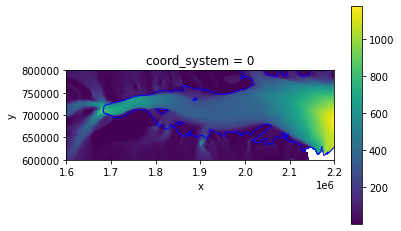

In [205]:
fig,ax = plt.subplots()
velocity_transformed.coarsen(x=50,y=50).mean().plot(ax=ax)
ice_shelf_shape.geometry.plot(ax=ax,facecolor='None', edgecolor='b')

In [85]:
velocity_img = velocity_transformed.coarsen(x=50,y=50).mean()

In [86]:
velocity_img = velocity_img.fillna(-999)

/srv/conda/envs/notebook/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


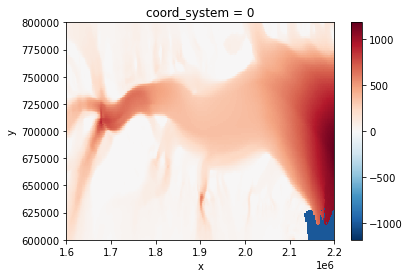

In [87]:
velocity_img.plot()


In [88]:
from skimage.segmentation import felzenszwalb, slic, quickshift, watershed
from skimage.segmentation import mark_boundaries

In [164]:
velocity_segments_fz = skimage.segmentation.felzenszwalb(velocity_img.data, scale=5000, sigma=1, min_size=100)
#velocity_segments_slic = slic(velocity_img.data, n_segments=100, compactness=10, sigma=1,
#                     start_label=1)

/srv/conda/envs/notebook/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


/srv/conda/envs/notebook/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


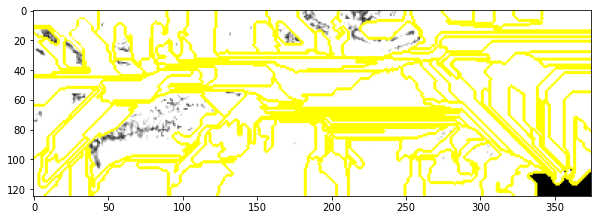

In [165]:
fig, ax = plt.subplots(nrows=1, figsize=(10, 10), sharex=True, sharey=True)

ax.imshow(mark_boundaries(velocity_img.data, velocity_segments_fz))


<AxesSubplot:xlabel='y', ylabel='x'>

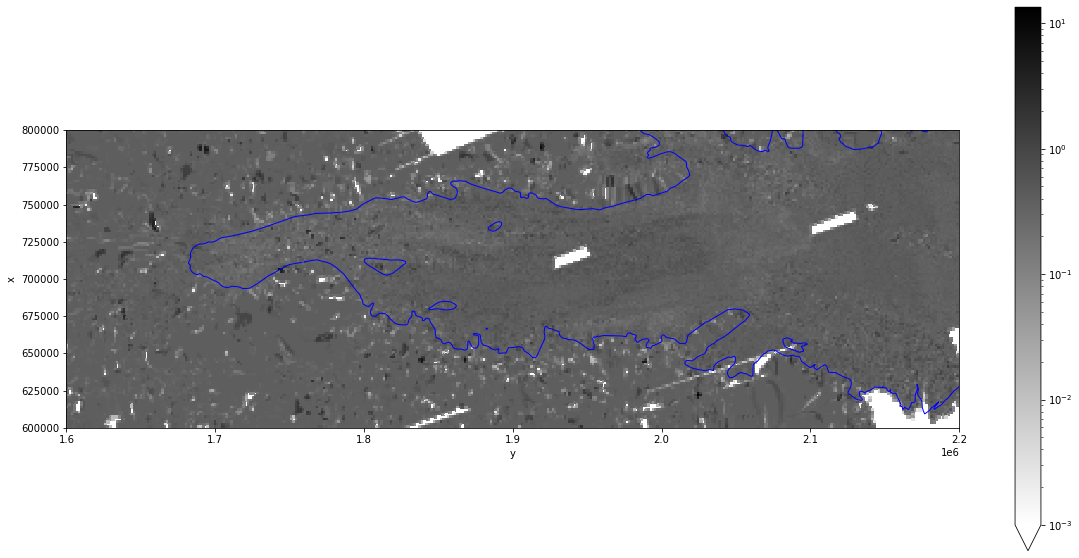

In [206]:
fig,ax = plt.subplots(figsize=(20,10))
area_to_volume_map.transpose().coarsen(x=50,y=50).mean().plot(ax=ax,cmap='binary',norm=mpl.colors.LogNorm(vmin=0.001, vmax=area_to_volume_map.data.max()))
ice_shelf_shape.geometry.plot(ax=ax,facecolor='None', edgecolor='b')

In [207]:
img = area_to_volume_map.transpose().fillna(-999).coarsen(x=50,y=50).mean()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 1.0, "Felzenszwalbs's method")

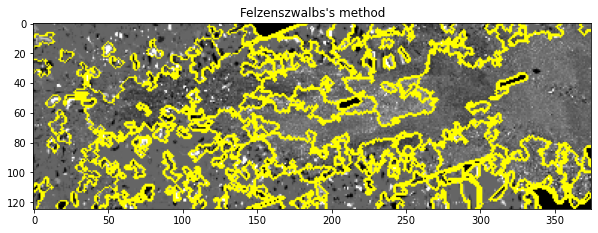

In [211]:
segments_fz = felzenszwalb(img.data, scale=100, sigma=0.5, min_size=25)



fig, ax = plt.subplots(figsize=(10, 10), sharex=True, sharey=True)

plt.imshow(mark_boundaries(img.data, segments_fz))
plt.title("Felzenszwalbs's method")
#ice_shelf_shape.geometry.plot(ax=ax,facecolor='None', edgecolor='b')

In [100]:
correlation2d = scipy.signal.correlate2d(skimage.segmentation.find_boundaries(velocity_segments_fz).astype(int),
                        skimage.segmentation.find_boundaries(segments_fz).astype(int),
                                        boundary='symm', mode='full')

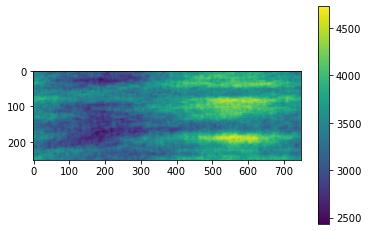

In [101]:
plt.imshow(correlation2d)
plt.colorbar()

In [223]:
sigmas = np.arange(1,20)/10

correlation_matrix = np.zeros((img.shape[0],img.shape[1],len(sigmas)))
for i,sigma_parameter in enumerate(sigmas):
    segments_fz = felzenszwalb(img.data, scale=100, sigma=sigma_parameter, min_size=25)
    correlation = scipy.signal.correlate2d(skimage.segmentation.find_boundaries(velocity_segments_fz).astype(int),
                        skimage.segmentation.find_boundaries(segments_fz).astype(int),
                        boundary='symm', mode='same')    
    correlation_matrix[:,:,i] = correlation

In [228]:
correlation_sigma = xr.DataArray(data=correlation_matrix,dims=['x','y','sigma'],coords=[img.x,img.y,sigmas])

<AxesSubplot:xlabel='y', ylabel='x'>

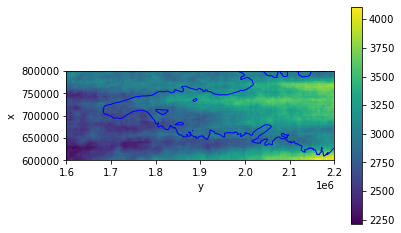

In [233]:
fig,ax=plt.subplots()
correlation_sigma.mean(dim='sigma').plot(ax=ax)
ice_shelf_shape.geometry.plot(ax=ax,facecolor='None', edgecolor='b')

In [236]:
scales = np.arange(50,1000,50)

correlation_matrix = np.zeros((img.shape[0],img.shape[1],len(scales)))
for i,scale_parameter in enumerate(scales):
    segments_fz = felzenszwalb(img.data, scale=scale_parameter, sigma=0.5, min_size=25)
    correlation = scipy.signal.correlate2d(skimage.segmentation.find_boundaries(velocity_segments_fz).astype(int),
                        skimage.segmentation.find_boundaries(segments_fz).astype(int),
                        boundary='symm', mode='same')    
    correlation_matrix[:,:,i] = correlation

In [237]:
correlation_scale = xr.DataArray(data=correlation_matrix,dims=['x','y','scale'],coords=[img.x,img.y,scales])

<AxesSubplot:xlabel='y', ylabel='x'>

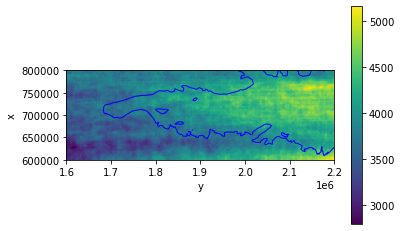

In [242]:
fig,ax=plt.subplots()
correlation_scale.max(dim='scale').plot(ax=ax)
ice_shelf_shape.geometry.plot(ax=ax,facecolor='None', edgecolor='b')

In [106]:
coords_formatted = {}
for index,coord in DB_merged_prop.coords.iteritems():
    
    coords_formatted[index] = np.int_([x.strip('[ ]') for x in DB_merged_prop['coords'][index].strip('[ ]').split(',')])
    

DB_merged_prop['coords_reformatted'] = coords_formatted.values()

#del coords_str
#del coords_list
del coords_formatted


NotImplementedError: Series getitem in only supported for other series objects with matching partition structure